# Step 1: Setup Google Colab Environment and Import Libraries

In [ ]:
# Install necessary packages
!pip install tensorflow -q
!pip install opencv-python -q
!pip install matplotlib -q
!pip install nibabel -q
!pip install scikit-learn -q
!pip install scikit-image -q

# Import libraries
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nibabel as nib
import h5py
import glob
import random
from skimage.transform import resize
from tqdm.keras import TqdmCallback
from tensorflow.keras import layers, models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

# Step 2: Mount Google Drive and Extract the Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your BraTS2020.zip file
zip_path = "/content/drive/My Drive/BraTS2020.zip"  # Update this path as needed

# Extract the zip file
extract_path = "/content/BraTS2020_extracted"
!mkdir -p {extract_path}
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Path to your data folder
data_dir = f"{extract_path}/BraTS2020_training_data/content/data"
print(f"Data directory: {data_dir}")

# List files in the data directory
files = os.listdir(data_dir)
print(f"Total files: {len(files)}")
print("Sample files:", files[:5])

# Load metadata
meta_data_path = os.path.join(data_dir, "meta_data.csv")
name_mapping_path = os.path.join(data_dir, "name_mapping.csv")
survival_info_path = os.path.join(data_dir, "survival_info.csv")

meta_data = pd.read_csv(meta_data_path)
name_mapping = pd.read_csv(name_mapping_path)
survival_info = pd.read_csv(survival_info_path)

print("\nMeta data sample:")
print(meta_data.head())
print("\nName mapping sample:")
print(name_mapping.head())
print("\nSurvival info sample:")
print(survival_info.head())

Mounted at /content/drive
Data directory: /content/BraTS2020_extracted/BraTS2020_training_data/content/data
Total files: 57198
Sample files: ['volume_88_slice_121.h5', 'volume_170_slice_73.h5', 'volume_50_slice_20.h5', 'volume_77_slice_96.h5', 'volume_134_slice_76.h5']

Meta data sample:
                           slice_path  target  volume  slice
0  /content/data/volume_41_slice_0.h5       0      41      0
1  /content/data/volume_41_slice_1.h5       0      41      1
2  /content/data/volume_41_slice_2.h5       0      41      2
3  /content/data/volume_41_slice_3.h5       0      41      3
4  /content/data/volume_41_slice_4.h5       0      41      4

Name mapping sample:
  Grade BraTS_2017_subject_ID BraTS_2018_subject_ID TCGA_TCIA_subject_ID  \
0   HGG   Brats17_CBICA_AAB_1   Brats18_CBICA_AAB_1                  NaN   
1   HGG   Brats17_CBICA_AAG_1   Brats18_CBICA_AAG_1                  NaN   
2   HGG   Brats17_CBICA_AAL_1   Brats18_CBICA_AAL_1                  NaN   
3   HGG   Brats17_C

# Step 3: Data Exploration and Preprocessing


Processing file: volume_46_slice_105.h5
 Keys in file: ['image', 'mask']
 Image shape: (240, 240, 4)
 Mask shape: (240, 240)
 Unique mask values: [0]


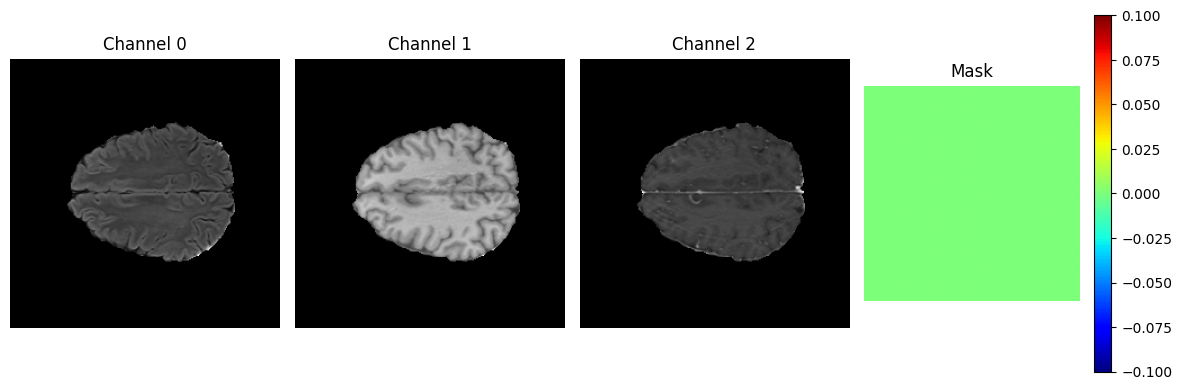


Processing file: volume_131_slice_120.h5
 Keys in file: ['image', 'mask']
 Image shape: (240, 240, 4)
 Mask shape: (240, 240)
 Unique mask values: [0 1]


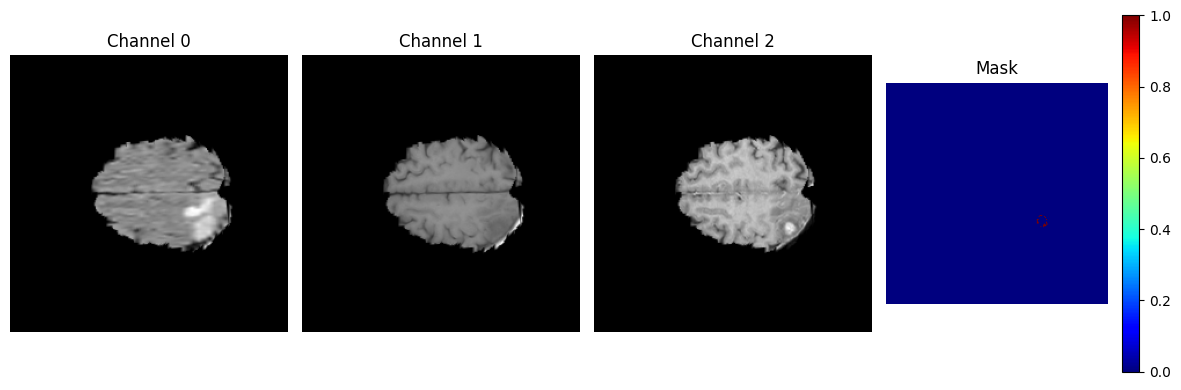


Processing file: volume_211_slice_51.h5
 Keys in file: ['image', 'mask']
 Image shape: (240, 240, 4)
 Mask shape: (240, 240)
 Unique mask values: [0 1]


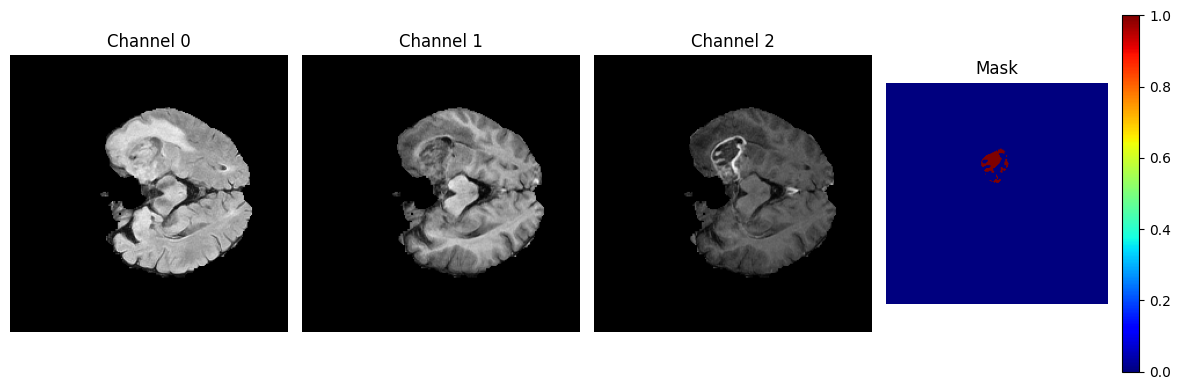

Preprocessed 57195 samples
Image shape: (57195, 128, 128, 4)
Mask shape: (57195, 128, 128, 1)

Visualizing a preprocessed sample...


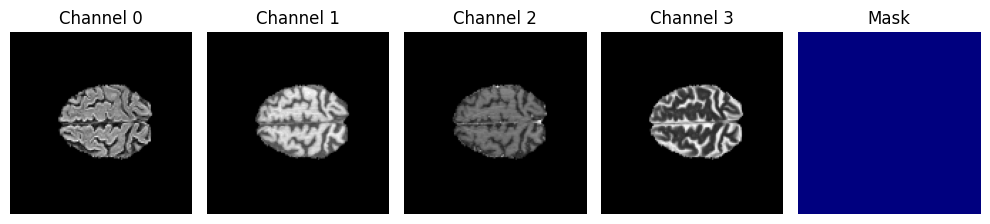

In [ ]:
from skimage.transform import resize

data_dir = "BraTS2020_extracted/BraTS2020_training_data/content/data"

def load_h5_slice(file_path, normalize=True, binarize_mask=True, verbose=True):
    """
    Load image and mask from a .h5 file with fallback support.
    """
    with h5py.File(file_path, 'r') as hf:
        keys = list(hf.keys())
        if verbose:
            print(f" Keys in file: {keys}")

        # Load image
        image_key = next((k for k in keys if 'image' in k.lower()), keys[0])
        image = np.array(hf[image_key])

        # Fix shape to channel-last
        if image.ndim == 3 and image.shape[0] <= 4:
            image = np.transpose(image, (1, 2, 0))

        if normalize:
            image = image.astype(np.float32)
            image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

        # Load mask
        mask_keys = [k for k in keys if 'mask' in k.lower() or 'seg' in k.lower() or 'label' in k.lower()]
        if mask_keys:
            mask = np.array(hf[mask_keys[0]])
        else:
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

        # Ensure the mask is 2D
        if mask.ndim == 3:
            mask = mask[:, :, 0]

        # Binarize mask if needed
        if binarize_mask:
            mask = (mask > 0).astype(np.uint8)

        # Ensure the mask has the same height and width as the image
        if mask.shape != image.shape[:2]:
            mask = resize(mask, (image.shape[0], image.shape[1]), order=0, mode='constant', cval=0)

        if verbose:
            print(f" Image shape: {image.shape}")
            print(f" Mask shape: {mask.shape}")
            print(f" Unique mask values: {np.unique(mask)}")

    return image, mask


def preprocess_dataset(file_list, data_dir, target_shape=(128, 128)):
    """
    Load and preprocess the dataset from .h5 files.
    """
    images = []
    masks = []

    for file in file_list:
        file_path = os.path.join(data_dir, file)
        try:
            image, mask = load_h5_slice(file_path, normalize=True, binarize_mask=True, verbose=False)

            # Resize image and mask
            image_resized = resize(image, (*target_shape, image.shape[-1]), preserve_range=True, anti_aliasing=True)
            mask_resized = resize(mask, target_shape, preserve_range=True, anti_aliasing=False, order=0)
            mask_resized = (mask_resized > 0.5).astype(np.uint8)

            images.append(image_resized)
            masks.append(mask_resized[..., np.newaxis])  # Add channel dim

        except Exception as e:
            print(f"Skipping {file}: {str(e)}")

    X = np.array(images, dtype=np.float32)
    y = np.array(masks, dtype=np.uint8)

    print(f"Preprocessed {len(X)} samples")
    print(f"Image shape: {X.shape}")
    print(f"Mask shape: {y.shape}")

    return X, y


# Step 1: List files and visualize some raw slices
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]
sample_files = random.sample(h5_files, 3)  # Pick any 3 random files


for file in sample_files:
    file_path = os.path.join(data_dir, file)
    print(f"\nProcessing file: {file}")
    try:
        image, mask = load_h5_slice(file_path)
        plt.figure(figsize=(12, 4))

        for i in range(min(image.shape[-1], 3)):
            plt.subplot(1, 4, i + 1)
            plt.imshow(image[:, :, i], cmap='gray')
            plt.title(f'Channel {i}')
            plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(mask, cmap='jet')
        plt.title('Mask')
        plt.axis('off')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Failed to process {file}: {str(e)}")


# Step 2: Preprocess the full dataset
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]  # Get all .h5 files

# Preprocess the full dataset
X, y = preprocess_dataset(h5_files, data_dir, target_shape=(128, 128))


# Step 3: Post-preprocessing visualization
print("\nVisualizing a preprocessed sample...")
idx = 0
plt.figure(figsize=(10, 4))
for i in range(X.shape[-1]):
    plt.subplot(1, X.shape[-1] + 1, i + 1)
    plt.imshow(X[idx, :, :, i], cmap='gray')
    plt.title(f'Channel {i}')
    plt.axis('off')

plt.subplot(1, X.shape[-1] + 1, X.shape[-1] + 1)
plt.imshow(y[idx, :, :, 0], cmap='jet')
plt.title('Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

# Step 4: Prepare Data for Model Training

In [ ]:
#  Dice coefficient (if you want to use it later in model metrics)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# Load and preprocess a single h5 file
def load_h5_slice(file_path, normalize=True, binarize_mask=True):
    with h5py.File(file_path, 'r') as hf:
        keys = list(hf.keys())
        image_key = next((k for k in keys if 'image' in k.lower()), keys[0])
        image = np.array(hf[image_key])

        if image.ndim == 3 and image.shape[0] <= 4:
            image = np.transpose(image, (1, 2, 0))
        if image.shape[-1] > 4:
            image = image[..., :4]

        if normalize:
            image = image.astype(np.float32)
            image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)

        mask_keys = [k for k in keys if 'mask' in k.lower() or 'seg' in k.lower() or 'label' in k.lower()]
        mask = np.array(hf[mask_keys[0]]) if mask_keys else np.zeros(image.shape[:2], dtype=np.uint8)

        if mask.ndim == 3:
            mask = mask[:, :, 0]
        if binarize_mask:
            mask = (mask > 0).astype(np.uint8)
        if mask.shape != image.shape[:2]:
            mask = resize(mask, (image.shape[0], image.shape[1]), order=0, mode='constant', cval=0)

    return image, mask

#  Save .npy chunks
def save_npy_in_chunks(file_list, data_dir, prefix, chunk_size=5000, target_shape=(128, 128)):
    def preprocess_dataset(files):
        images, masks = [], []
        for file in files:
            try:
                image, mask = load_h5_slice(os.path.join(data_dir, file))
                image_resized = resize(image, (*target_shape, image.shape[-1]), preserve_range=True, anti_aliasing=True)
                mask_resized = resize(mask, target_shape, preserve_range=True, anti_aliasing=False, order=0)
                mask_resized = (mask_resized > 0.5).astype(np.uint8)
                images.append(image_resized)
                masks.append(mask_resized[..., np.newaxis])
            except Exception as e:
                print(f"Skipping {file}: {e}")
        return np.array(images, dtype=np.float32), np.array(masks, dtype=np.uint8)

    for i, start in enumerate(range(0, len(file_list), chunk_size)):
        end = min(start + chunk_size, len(file_list))
        chunk_files = file_list[start:end]
        X_chunk, y_chunk = preprocess_dataset(chunk_files)
        np.save(f"/content/{prefix}_X_part{i}.npy", X_chunk)
        np.save(f"/content/{prefix}_y_part{i}.npy", y_chunk)
        print(f"✅ Saved: {prefix}_X_part{i}.npy & {prefix}_y_part{i}.npy | Samples: {len(X_chunk)}")

# Load .npy files as streaming dataset
def dataset_from_npy_chunks(prefix, batch_size=32):
    X_files = sorted(glob.glob(f"/content/{prefix}_X_part*.npy"))
    y_files = sorted(glob.glob(f"/content/{prefix}_y_part*.npy"))

    def generator():
        for x_path, y_path in zip(X_files, y_files):
            X = np.load(x_path)
            y = np.load(y_path)
            for i in range(len(X)):
                yield X[i], y[i]

    output_signature = (
        tf.TensorSpec(shape=(128, 128, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(128, 128, 1), dtype=tf.uint8)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature) \
        .shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Run everything
data_dir = "/content/BraTS2020_extracted/BraTS2020_training_data/content/data"
h5_files = [f for f in os.listdir(data_dir) if f.endswith(".h5")]

# Split into train, val, test
train_files, test_files = train_test_split(h5_files, test_size=0.2, random_state=42)
valid_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

# Save all .npy chunks
save_npy_in_chunks(train_files, data_dir, prefix="train", chunk_size=5000)
save_npy_in_chunks(valid_files, data_dir, prefix="val", chunk_size=2000)
save_npy_in_chunks(test_files, data_dir, prefix="test", chunk_size=2000)

# Create TensorFlow Datasets (streamed from disk)
batch_size = 32
train_dataset = dataset_from_npy_chunks("train", batch_size)
valid_dataset = dataset_from_npy_chunks("val", batch_size)
test_dataset  = dataset_from_npy_chunks("test", batch_size)

# Print dataset sizes
train_len = sum([np.load(f).shape[0] for f in glob.glob("/content/train_X_part*.npy")])
val_len   = sum([np.load(f).shape[0] for f in glob.glob("/content/val_X_part*.npy")])
test_len  = sum([np.load(f).shape[0] for f in glob.glob("/content/test_X_part*.npy")])

print(f"\n Dataset Sizes:\nTrain: {train_len}\nVal: {val_len}\nTest: {test_len}")


✅ Saved: train_X_part0.npy & train_y_part0.npy | Samples: 5000
✅ Saved: train_X_part1.npy & train_y_part1.npy | Samples: 5000
✅ Saved: train_X_part2.npy & train_y_part2.npy | Samples: 5000
✅ Saved: train_X_part3.npy & train_y_part3.npy | Samples: 5000
✅ Saved: train_X_part4.npy & train_y_part4.npy | Samples: 5000
✅ Saved: train_X_part5.npy & train_y_part5.npy | Samples: 5000
✅ Saved: train_X_part6.npy & train_y_part6.npy | Samples: 5000
✅ Saved: train_X_part7.npy & train_y_part7.npy | Samples: 5000
✅ Saved: train_X_part8.npy & train_y_part8.npy | Samples: 5000
✅ Saved: train_X_part9.npy & train_y_part9.npy | Samples: 756
✅ Saved: val_X_part0.npy & val_y_part0.npy | Samples: 2000
✅ Saved: val_X_part1.npy & val_y_part1.npy | Samples: 2000
✅ Saved: val_X_part2.npy & val_y_part2.npy | Samples: 1719
✅ Saved: test_X_part0.npy & test_y_part0.npy | Samples: 2000
✅ Saved: test_X_part1.npy & test_y_part1.npy | Samples: 2000
✅ Saved: test_X_part2.npy & test_y_part2.npy | Samples: 1720

 Dataset S

# Step 5: Create U-Net Model for Segmentation

In [ ]:
# -----------------------------------------------
# Define U-Net Architecture
# -----------------------------------------------
def unet_model(input_shape=(128, 128, 4), num_classes=1):
    inputs = Input(input_shape)

    # ----- Encoder -----
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    d4 = Dropout(0.5)(c4)
    p4 = MaxPooling2D((2, 2))(d4)

    # ----- Bottleneck -----
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    d5 = Dropout(0.5)(c5)

    # ----- Decoder -----
    u6 = UpSampling2D((2, 2))(d5)
    u6 = concatenate([u6, d4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

#  Create and summarize the model
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,403,073 (119.79 MB)

 Trainable params: 31,391,297 (119.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Step 6: Train the U-Net Model

In [ ]:
# -----------------------------------------------
# Define custom training loop with tqdm
# -----------------------------------------------
def train_unet_with_tqdm(model, train_dataset, valid_dataset, train_size, valid_size,
                         epochs=50, batch_size=32):
    train_loss_history = []
    val_loss_history = []
    val_dice_history = []

    train_steps = train_size // batch_size
    val_steps = valid_size // batch_size

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # --- Training ---
        train_loss = 0
        with tqdm(total=train_steps, desc="Training", unit="batch") as pbar:
            for step, (X_batch, y_batch) in enumerate(train_dataset.take(train_steps)):
                loss_value, _ = model.train_on_batch(X_batch, y_batch)
                train_loss += loss_value
                pbar.set_postfix({"loss": f"{loss_value:.4f}"})
                pbar.update(1)

        avg_train_loss = train_loss / train_steps
        train_loss_history.append(avg_train_loss)

        # --- Validation ---
        val_loss = 0
        val_dice = 0
        with tqdm(total=val_steps, desc="Validation", unit="batch") as pbar:
            for step, (X_val, y_val) in enumerate(valid_dataset.take(val_steps)):
                loss_val, dice_val = model.test_on_batch(X_val, y_val)
                val_loss += loss_val
                val_dice += dice_val
                pbar.set_postfix({"val_loss": f"{loss_val:.4f}", "val_dice": f"{dice_val:.4f}"})
                pbar.update(1)

        avg_val_loss = val_loss / val_steps
        avg_val_dice = val_dice / val_steps
        val_loss_history.append(avg_val_loss)
        val_dice_history.append(avg_val_dice)

        print(f" Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Dice = {avg_val_dice:.4f}")

    return train_loss_history, val_loss_history, val_dice_history

In [ ]:
# Create directory to save best model
checkpoint_dir = "/content/best_model"
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "unet_best.h5"),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

tqdm_callback = TqdmCallback(verbose=1)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=[dice_coef])

# Train the model with callbacks
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint, tqdm_callback],
    steps_per_epoch=train_len // batch_size,
    validation_steps=val_len // batch_size
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 4))
  warnings.warn(msg)


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - dice_coef: 0.0099 - loss: 0.5052
Epoch 1: val_loss improved from inf to 0.09953, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 131s 66ms/step - dice_coef: 0.0099 - loss: 0.5051 - val_dice_coef: 0.0169 - val_loss: 0.0995 - learning_rate: 1.0000e-04
Epoch 2/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 7:16:33 18s/step - dice_coef: 0.0247 - loss: 0.1055

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.09953
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - dice_coef: 0.0247 - loss: 0.1055 - val_dice_coef: 0.0173 - val_loss: 0.1006 - learning_rate: 1.0000e-04
Epoch 3/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - dice_coef: 0.0462 - loss: 0.0694
Epoch 3: val_loss improved from 0.09953 to 0.02277, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - dice_coef: 0.0462 - loss: 0.0694 - val_dice_coef: 0.1226 - val_loss: 0.0228 - learning_rate: 1.0000e-04
Epoch 4/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:14 52ms/step - dice_coef: 0.0860 - loss: 0.0224
Epoch 4: val_loss improved from 0.02277 to 0.02268, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dice_coef: 0.0860 - loss: 0.0224 - val_dice_coef: 0.1200 - val_loss: 0.0227 - learning_rate: 1.0000e-04
Epoch 5/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - dice_coef: 0.1647 - loss: 0.0171
Epoch 5: val_loss improved from 0.02268 to 0.00859, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - dice_coef: 0.1647 - loss: 0.0171 - val_dice_coef: 0.2752 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 6/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:16 54ms/step - dice_coef: 0.2802 - loss: 0.0070
Epoch 6: val_loss improved from 0.00859 to 0.00857, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dice_coef: 0.2802 - loss: 0.0070 - val_dice_coef: 0.2778 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 7/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - dice_coef: 0.3501 - loss: 0.0072
Epoch 7: val_loss improved from 0.00857 to 0.00471, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 93s 64ms/step - dice_coef: 0.3501 - loss: 0.0072 - val_dice_coef: 0.4606 - val_loss: 0.0047 - learning_rate: 1.0000e-04
Epoch 8/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:15 53ms/step - dice_coef: 0.5770 - loss: 0.0047
Epoch 8: val_loss did not improve from 0.00471
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - dice_coef: 0.5770 - loss: 0.0047 - val_dice_coef: 0.4650 - val_loss: 0.0048 - learning_rate: 1.0000e-04
Epoch 9/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - dice_coef: 0.5202 - loss: 0.0041
Epoch 9: val_loss improved from 0.00471 to 0.00331, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - dice_coef: 0.5202 - loss: 0.0041 - val_dice_coef: 0.5987 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 10/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:14 52ms/step - dice_coef: 0.6355 - loss: 0.0027
Epoch 10: val_loss improved from 0.00331 to 0.00328, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dice_coef: 0.6355 - loss: 0.0027 - val_dice_coef: 0.5955 - val_loss: 0.0033 - learning_rate: 1.0000e-04
Epoch 11/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - dice_coef: 0.6315 - loss: 0.0029
Epoch 11: val_loss improved from 0.00328 to 0.00257, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - dice_coef: 0.6315 - loss: 0.0029 - val_dice_coef: 0.6717 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 12/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:15 53ms/step - dice_coef: 0.7284 - loss: 0.0027
Epoch 12: val_loss improved from 0.00257 to 0.00256, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dice_coef: 0.7284 - loss: 0.0027 - val_dice_coef: 0.6656 - val_loss: 0.0026 - learning_rate: 1.0000e-04
Epoch 13/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - dice_coef: 0.7101 - loss: 0.0023
Epoch 13: val_loss improved from 0.00256 to 0.00233, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - dice_coef: 0.7101 - loss: 0.0023 - val_dice_coef: 0.7060 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 14/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:15 53ms/step - dice_coef: 0.6764 - loss: 0.0020
Epoch 14: val_loss improved from 0.00233 to 0.00229, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dice_coef: 0.6764 - loss: 0.0020 - val_dice_coef: 0.7160 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 15/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - dice_coef: 0.7548 - loss: 0.0019
Epoch 15: val_loss improved from 0.00229 to 0.00189, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - dice_coef: 0.7548 - loss: 0.0019 - val_dice_coef: 0.7633 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 16/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:15 53ms/step - dice_coef: 0.7931 - loss: 0.0011
Epoch 16: val_loss improved from 0.00189 to 0.00185, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dice_coef: 0.7931 - loss: 0.0011 - val_dice_coef: 0.7656 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 17/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - dice_coef: 0.7871 - loss: 0.0017
Epoch 17: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 17: val_loss improved from 0.00185 to 0.00183, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 92s 64ms/step - dice_coef: 0.7871 - loss: 0.0017 - val_dice_coef: 0.7791 - val_loss: 0.0018 - learning_rate: 1.0000e-04
Epoch 18/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:15 53ms/step - dice_coef: 0.8156 - loss: 0.0022
Epoch 18: val_loss improved from 0.00183 to 0.00179, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - dice_coef: 0.8156 - loss: 0.0022 - val_dice_coef: 0.7845 - val_loss: 0.0018 - learning_rate: 5.0000e-05
Epoch 19/20
1429/1429 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - dice_coef: 0.8227 - loss: 0.0014
Epoch 19: val_loss improved from 0.00179 to 0.00139, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 93s 64ms/step - dice_coef: 0.8227 - loss: 0.0014 - val_dice_coef: 0.8127 - val_loss: 0.0014 - learning_rate: 5.0000e-05
Epoch 20/20
   1/1429 ━━━━━━━━━━━━━━━━━━━━ 1:15 53ms/step - dice_coef: 0.8280 - loss: 0.0013
Epoch 20: val_loss improved from 0.00139 to 0.00138, saving model to /content/best_model/unet_best.h5


1429/1429 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - dice_coef: 0.8280 - loss: 0.0013 - val_dice_coef: 0.8254 - val_loss: 0.0014 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 20.


In [ ]:
# Copy the file to  Drive
!cp /content/best_model/unet_best.h5 /content/drive/MyDrive/

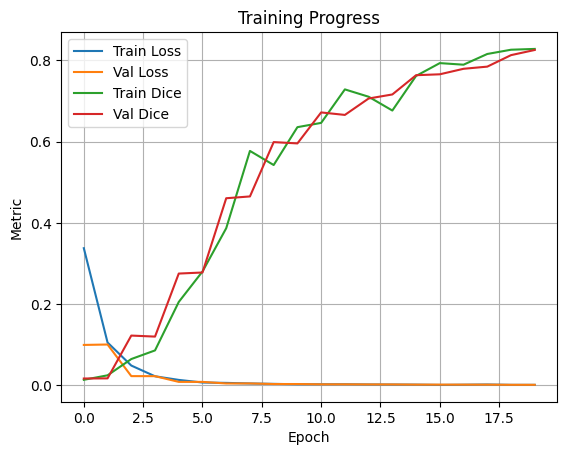

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.title("Training Progress")
plt.legend()
plt.grid(True)
plt.show()


# Step 7: Prepare Data for Object Detection

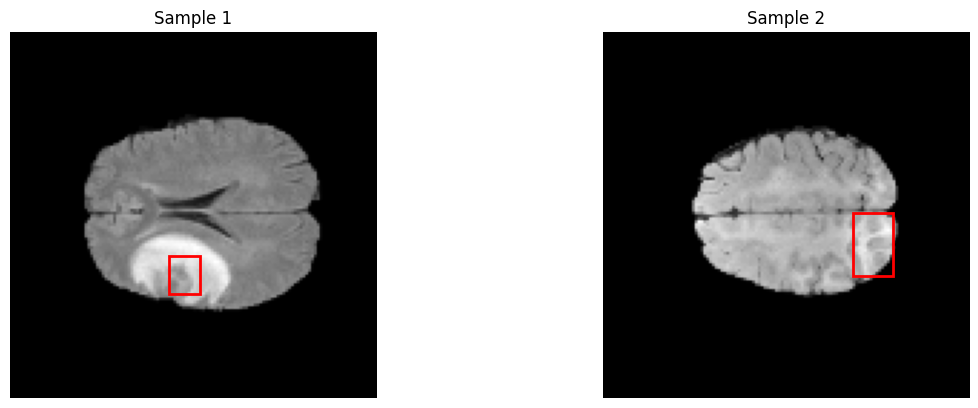

In [ ]:
# Convert masks to bounding boxes [x_min, y_min, x_max, y_max]
def masks_to_boxes(masks):
    boxes = []
    for mask in masks:
        if mask.ndim == 3:
            mask = mask[:, :, 0]
        if np.sum(mask) == 0:
            boxes.append(None)  # No object present
            continue
        rows = np.any(mask, axis=1)
        cols = np.any(mask, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        boxes.append([cmin, rmin, cmax, rmax])
    return boxes

# Generate bounding boxes and save for all chunks
def generate_and_save_bboxes(prefix):
    x_files = sorted(glob.glob(f"/content/{prefix}_X_part*.npy"))
    y_files = sorted(glob.glob(f"/content/{prefix}_y_part*.npy"))

    for i, (x_path, y_path) in enumerate(zip(x_files, y_files)):
        masks = np.load(y_path)
        boxes = masks_to_boxes(masks)
        np.save(f"/content/{prefix}_bboxes_part{i}.npy", np.array(boxes, dtype=object))

# Run for all splits
generate_and_save_bboxes("train")
generate_and_save_bboxes("val")
generate_and_save_bboxes("test")

# Optional: Visualize a few samples from train set
X_sample = np.load("/content/train_X_part0.npy")[:2]
bboxes_sample = np.load("/content/train_bboxes_part0.npy", allow_pickle=True)[:10]

plt.figure(figsize=(12, 8))
for i in range(len(X_sample)):
    plt.subplot(2, 2, i + 1)
    plt.imshow(X_sample[i, :, :, 0], cmap='gray')
    if bboxes_sample[i] is not None:
        x_min, y_min, x_max, y_max = bboxes_sample[i]
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Step 8: Build a Simple Object Detection Model

In [ ]:
# -------------------------------
# Load image and bounding box data
# -------------------------------
X_paths = sorted(glob.glob("/content/train_X_part*.npy"))
bbox_paths = sorted(glob.glob("/content/train_bboxes_part*.npy"))

X_all = np.concatenate([np.load(x) for x in X_paths])
bbox_all = np.concatenate([np.load(b, allow_pickle=True) for b in bbox_paths])

# -------------------------------
# Filter out entries with no boxes
# -------------------------------
X_filtered, y_filtered = [], []
for img, box in zip(X_all, bbox_all):
    if box is not None:
        X_filtered.append(img)
        y_filtered.append(box)

X_filtered = np.array(X_filtered, dtype=np.float32)
y_filtered = np.array(y_filtered, dtype=np.float32)

# -------------------------------
# Normalize bounding boxes to [0, 1]
# -------------------------------
H, W = X_filtered.shape[1:3]
y_normalized = y_filtered.copy()
y_normalized[:, [0, 2]] /= W  # x_min, x_max
y_normalized[:, [1, 3]] /= H  # y_min, y_max

# -------------------------------
# Custom IoU Loss
# -------------------------------
def iou_loss(y_true, y_pred):
    x1 = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y1 = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x2 = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y2 = tf.minimum(y_true[..., 3], y_pred[..., 3])

    intersection = tf.maximum(0.0, x2 - x1) * tf.maximum(0.0, y2 - y1)
    area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])
    union = area_true + area_pred - intersection

    iou = intersection / (union + 1e-6)
    return 1.0 - iou

# -------------------------------
# Cosine Learning Rate Scheduler
# -------------------------------
def cosine_decay(epoch, lr):
    initial_lr = 0.001
    return initial_lr * 0.5 * (1 + np.cos(np.pi * epoch / 30))

# -------------------------------
# Build Model with MobileNetV2 + Dropout + BatchNorm
# -------------------------------
def build_improved_detector(input_shape=(128, 128, 4)):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights=None)
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(4, activation='sigmoid')(x)
    return models.Model(inputs=base.input, outputs=outputs)

# Build and compile
detector = build_improved_detector()
detector.compile(optimizer='adam', loss=iou_loss)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v2.py:210: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 4 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_loss improved from inf to 0.93972, saving model to /content/best_detector_iou.h5



Epoch 2: val_loss did not improve from 0.93972

Epoch 3: val_loss did not improve from 0.93972

Epoch 4: val_loss did not improve from 0.93972

Epoch 5: val_loss did not improve from 0.93972

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000466506346128881.

Epoch 6: val_loss did not improve from 0.93972

Epoch 7: val_loss did not improve from 0.93972

Epoch 8: val_loss improved from 0.93972 to 0.88501, saving model to /content/best_detector_iou.h5



Epoch 9: val_loss did not improve from 0.88501

Epoch 10: val_loss improved from 0.88501 to 0.72850, saving model to /content/best_detector_iou.h5



Epoch 11: val_loss did not improve from 0.72850

Epoch 12: val_loss did not improve from 0.72850

Epoch 13: val_loss improved from 0.72850 to 0.65022, saving model to /content/best_detector_iou.h5



Epoch 14: val_loss did not improve from 0.65022

Epoch 15: val_loss did not improve from 0.65022

Epoch 16: val_loss improved from 0.65022 to 0.64523, saving model to /content/best_detector_iou.h5



Epoch 17: val_loss improved from 0.64523 to 0.57510, saving model to /content/best_detector_iou.h5



Epoch 18: val_loss did not improve from 0.57510

Epoch 19: val_loss did not improve from 0.57510

Epoch 20: val_loss improved from 0.57510 to 0.56312, saving model to /content/best_detector_iou.h5



Epoch 21: val_loss did not improve from 0.56312

Epoch 22: val_loss improved from 0.56312 to 0.55675, saving model to /content/best_detector_iou.h5



Epoch 23: val_loss improved from 0.55675 to 0.50679, saving model to /content/best_detector_iou.h5



Epoch 24: val_loss did not improve from 0.50679

Epoch 25: val_loss improved from 0.50679 to 0.48691, saving model to /content/best_detector_iou.h5



Epoch 26: val_loss did not improve from 0.48691

Epoch 27: val_loss improved from 0.48691 to 0.47680, saving model to /content/best_detector_iou.h5



Epoch 28: val_loss improved from 0.47680 to 0.47217, saving model to /content/best_detector_iou.h5



Epoch 29: val_loss improved from 0.47217 to 0.47087, saving model to /content/best_detector_iou.h5



Epoch 30: val_loss improved from 0.47087 to 0.46647, saving model to /content/best_detector_iou.h5


Restoring model weights from the end of the best epoch: 30.


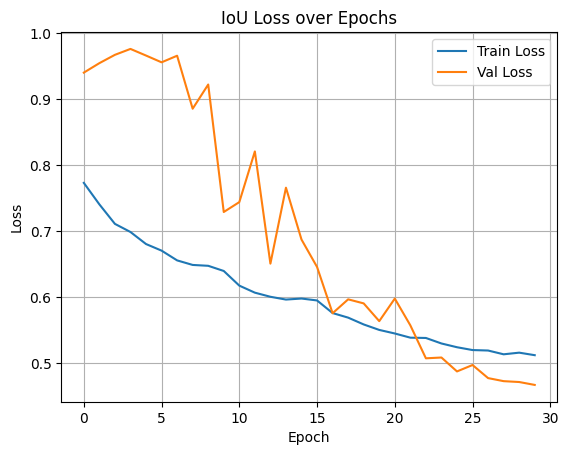

In [ ]:

# -------------------------------
# Train/Validation Split
# -------------------------------
X_train, X_val, y_train, y_val = train_test_split(X_filtered, y_normalized, test_size=0.1, random_state=42)

# -------------------------------
# Callbacks
# -------------------------------
callbacks = [
    TqdmCallback(verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    ModelCheckpoint('/content/best_detector_iou.h5', save_best_only=True, monitor='val_loss', verbose=1),
    LearningRateScheduler(cosine_decay)
]

# -------------------------------
# Training
# -------------------------------
history = detector.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

# -------------------------------
# Loss Curve
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("IoU Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Copy the file to  Drive
!cp /content/best_detector_iou.h5 /content/drive/MyDrive/

Calculating IoU: 100%|██████████| 38/38 [00:09<00:00,  3.85batch/s]


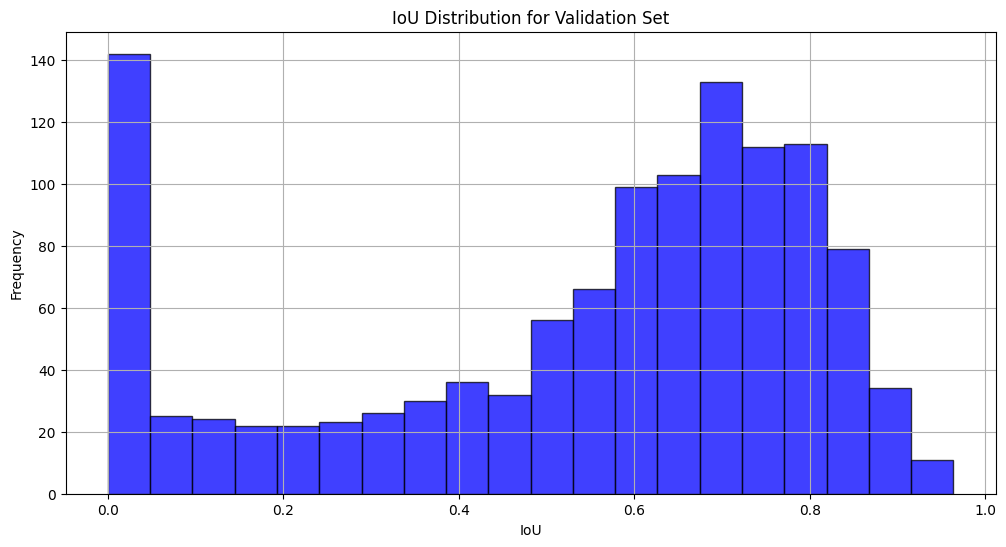

Mean IoU: 0.5335


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to calculate IoU for a batch
def calculate_batch_iou(y_true_batch, y_pred_batch):
    batch_iou = []
    for y_true, y_pred in zip(y_true_batch, y_pred_batch):
        # Calculate IoU for a single pair of true and predicted boxes
        x1 = np.maximum(y_true[0], y_pred[0])
        y1 = np.maximum(y_true[1], y_pred[1])
        x2 = np.minimum(y_true[2], y_pred[2])
        y2 = np.minimum(y_true[3], y_pred[3])

        intersection = np.maximum(0.0, x2 - x1) * np.maximum(0.0, y2 - y1)
        area_true = (y_true[2] - y_true[0]) * (y_true[3] - y_true[1])
        area_pred = (y_pred[2] - y_pred[0]) * (y_pred[3] - y_pred[1])
        union = area_true + area_pred - intersection

        iou = intersection / (union + 1e-6)  # Add small value to avoid division by zero
        batch_iou.append(iou)
    return batch_iou

# Function to calculate IoU over all validation data in batches
def calculate_iou_in_batches(X_val, y_val, batch_size=32):
    batch_iou_values = []
    num_batches = len(X_val) // batch_size + (1 if len(X_val) % batch_size != 0 else 0)

    # Iterate over batches
    for i in tqdm(range(num_batches), desc="Calculating IoU", unit="batch"):
        # Get the batch data
        start = i * batch_size
        end = min((i + 1) * batch_size, len(X_val))

        y_pred_batch = detector.predict(X_val[start:end], verbose=0)  # Predict for the batch
        y_true_batch = y_val[start:end]  # True boxes for the batch

        # Calculate IoU for this batch
        batch_iou = calculate_batch_iou(y_true_batch, y_pred_batch)
        batch_iou_values.extend(batch_iou)

    return batch_iou_values

# Calculate IoU for all validation data in batches
batch_iou_values = calculate_iou_in_batches(X_val, y_val, batch_size=32)

# Plot IoU distribution
plt.figure(figsize=(12, 6))
plt.hist(batch_iou_values, bins=20, alpha=0.75, color='b', edgecolor='black')
plt.title("IoU Distribution for Validation Set")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Calculate Mean IoU
mean_iou = np.mean(batch_iou_values)
print(f"Mean IoU: {mean_iou:.4f}")


# Step 9: Evaluate Segmentation and Detection Models

## Evaluation Code for U-Net (Segmentation):

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 4))
  warnings.warn(msg)


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step
Average Dice coefficient on test set: 0.9081


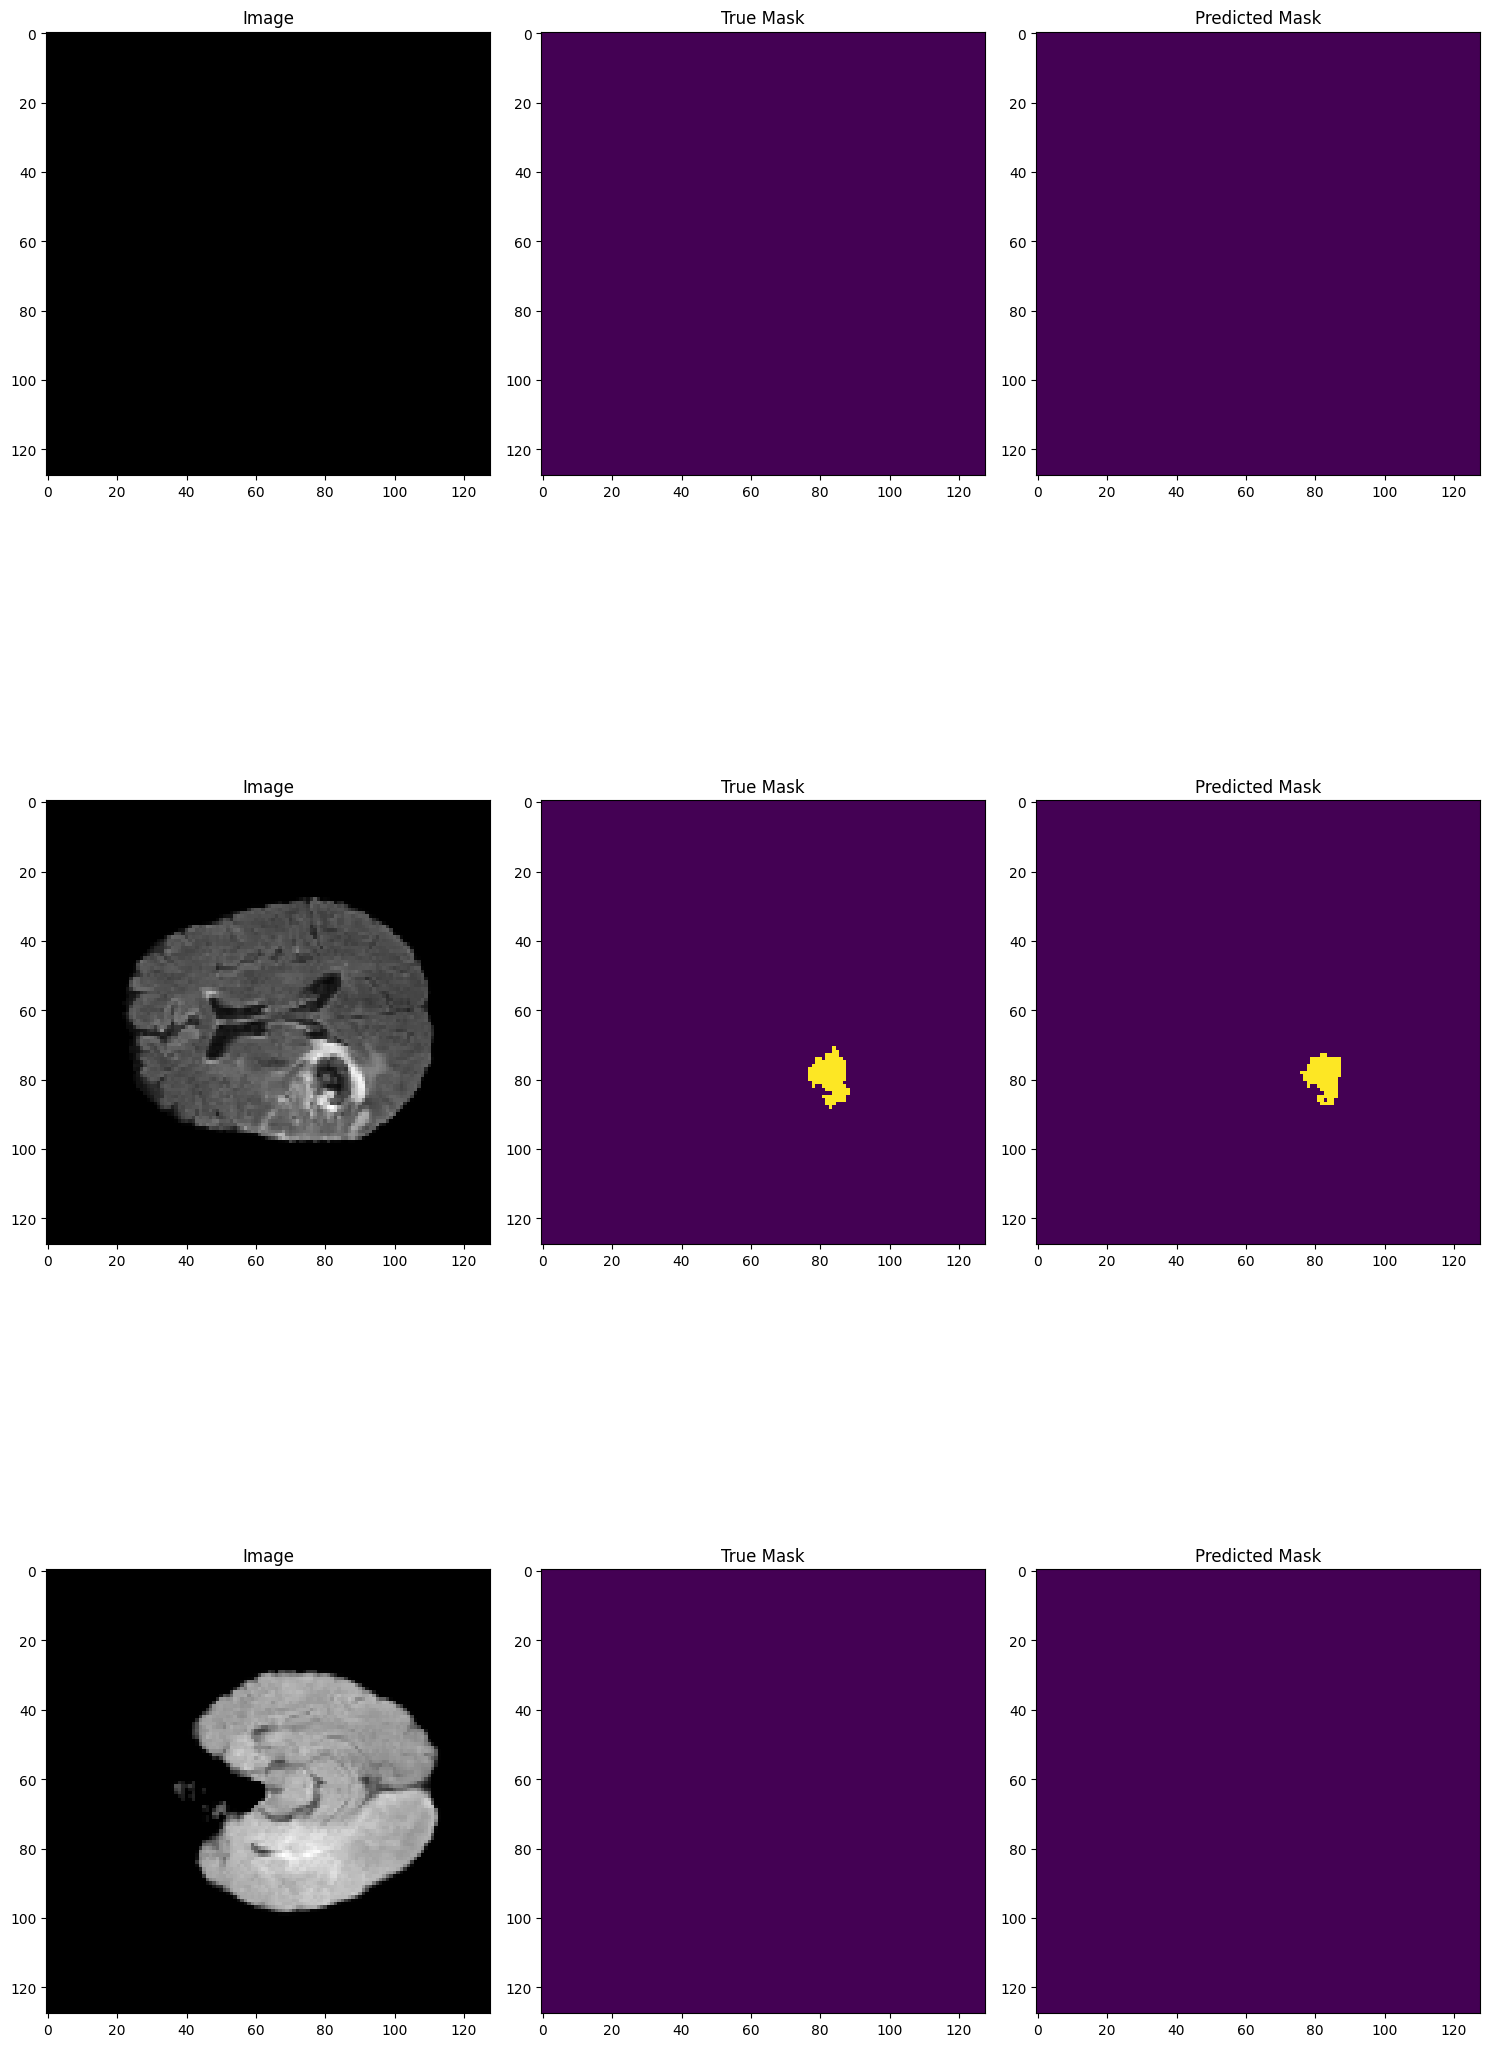

In [ ]:
X_test = np.load("/content/test_X_part0.npy")
y_test = np.load("/content/test_y_part0.npy")

def evaluate_segmentation_test(model, X_test, y_test):
    """Evaluate the segmentation model on the test set."""
    # Predict masks
    y_pred = model.predict(X_test)

    # Calculate Dice coefficient
    def dice_coefficient(y_true, y_pred, smooth=1e-6):
        y_true_f = y_true.flatten()
        y_pred_f = y_pred.flatten()
        intersection = np.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

    # Calculate Dice for each sample and average
    dice_scores = []
    for i in range(len(y_test)):
        dice = dice_coefficient(y_test[i].flatten(), (y_pred[i] > 0.5).flatten())
        dice_scores.append(dice)

    avg_dice = np.mean(dice_scores)
    print(f"Average Dice coefficient on test set: {avg_dice:.4f}")

    # Visualize some results
    fig, axes = plt.subplots(3, 3, figsize=(15, 25))
    for i in range(3):
        idx = np.random.randint(0, len(X_test))

        # Original image
        axes[i, 0].imshow(X_test[idx, :, :, 0], cmap='gray')
        axes[i, 0].set_title('Image')

        # True mask
        axes[i, 1].imshow(y_test[idx, :, :, 0])
        axes[i, 1].set_title('True Mask')

        # Predicted mask
        axes[i, 2].imshow(y_pred[idx, :, :, 0] > 0.5)  # Threshold at 0.5
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

    return avg_dice

# Evaluate the segmentation model on the test set
seg_dice_test = evaluate_segmentation_test(model, X_test, y_test)

## Evaluate the Object Detection Model (MobileNetV2)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Mean IoU on test set: 0.5237


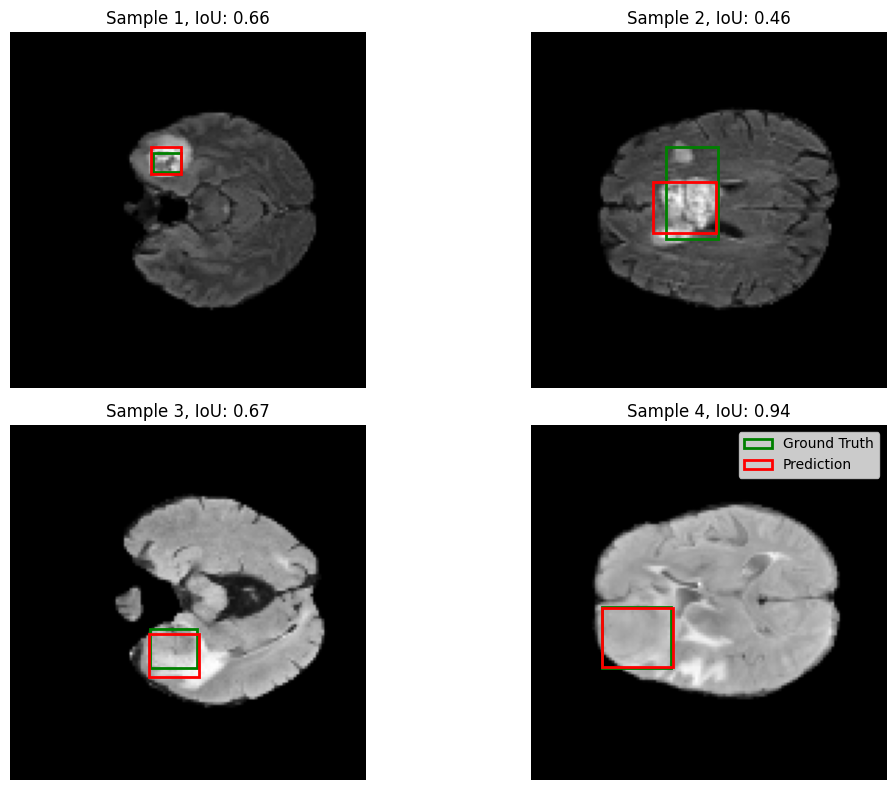

In [ ]:
def evaluate_object_detection_test(detector, X_test, y_test, H, W):
    """Evaluate the object detection model on the test set."""

    # Normalize bounding boxes in the test set
    y_test_normalized = y_test.copy()
    y_test_normalized[:, [0, 2]] /= W  # x_min, x_max
    y_test_normalized[:, [1, 3]] /= H  # y_min, y_max

    # Predict bounding boxes for test data
    y_pred = detector.predict(X_test)

    # Calculate IoU for the test set
    test_iou_values = calculate_batch_iou(y_test_normalized, y_pred)

    # Calculate Mean IoU for test set
    mean_iou_test = np.mean(test_iou_values)
    print(f"Mean IoU on test set: {mean_iou_test:.4f}")

    # Visualize some predictions
    plt.figure(figsize=(12, 8))
    for i in range(min(len(X_test), 4)): # Visualize a maximum of 4 samples
        plt.subplot(2, 2, i+1)
        plt.imshow(X_test[i, :, :, 0], cmap='gray')

        # Draw ground truth bounding box
        x_min_true, y_min_true, x_max_true, y_max_true = y_test_normalized[i] * np.array([W, H, W, H])
        rect_true = plt.Rectangle((x_min_true, y_min_true), x_max_true - x_min_true, y_max_true - y_min_true, fill=False, edgecolor='green', linewidth=2, label='Ground Truth')
        plt.gca().add_patch(rect_true)

        # Draw predicted bounding box
        x_min_pred, y_min_pred, x_max_pred, y_max_pred = y_pred[i] * np.array([W, H, W, H])
        rect_pred = plt.Rectangle((x_min_pred, y_min_pred), x_max_pred - x_min_pred, y_max_pred - y_min_pred, fill=False, edgecolor='red', linewidth=2, label='Prediction')
        plt.gca().add_patch(rect_pred)

        plt.title(f"Sample {i+1}, IoU: {test_iou_values[i]:.2f}")
        plt.axis('off')

    plt.legend()
    plt.tight_layout()
    plt.show()


# Load test data (replace with your actual file paths)
X_test = np.load("/content/test_X_part0.npy")
y_test = np.load("/content/test_bboxes_part0.npy", allow_pickle=True)

# Filter out None values from y_test before evaluating
X_test_filtered, y_test_filtered = [], []
for img, box in zip(X_test, y_test):
  if box is not None:
    X_test_filtered.append(img)
    y_test_filtered.append(box)
X_test_filtered = np.array(X_test_filtered)
y_test_filtered = np.array(y_test_filtered, dtype=np.float32)

H, W = X_test_filtered.shape[1:3]  # Assuming consistent image shape in test set

#Evaluate the object detection model
evaluate_object_detection_test(detector, X_test_filtered, y_test_filtered, H, W)
